In [1]:
# Importando os módulos
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from warnings import simplefilter
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
simplefilter(action='ignore')
%matplotlib inline

In [2]:
# Carregando e visualizando os Dados
df = pd.DataFrame()
for chunk in pd.read_csv('adult.data',na_values= '?', chunksize = 100000):
    df = pd.concat([df,chunk])

In [3]:
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


# Descrição das Features

**age:** Idade.

**workclass:** Classe trabalhadora. Se a pessoa é funcionário público, autônomo, empresário etc.

**education:** Níveis de Escolaridade.

**education-num:** Código do Nível de Escolaridade.

**marital-status:** Estado Civil.

**occupation:** Ocupação (Suporte técnico, Conserto de arte, Outros serviços, Vendas, Exec-managerial, Prof-specialty, Manipuladores de limpeza, Machine-op-inspct, Adm-clerical, Pesca agropecuária, Transport-moving, Priv-house-serv, Serviço de Proteção, Forças Armadas)

**relationship:** Relacionamento (Esposa, Filha Própria, Marido, Não-familiar, Outro-parente, Solteira.)

**race:** Raça (Preto, branco, asiático-Pac-Islander, Amer-Indian-Eskimo, Outro.)

**sex:** Sexo(Feminino, Masculino).

**capital-gain:** Ganho de Capital.

**capital-loss:** Perda de Capital.

**hours-per-week:** Horas de trabalho por Semana.

**native-country:** País Nativo (Estados Unidos, Camboja, Inglaterra, Porto Rico, Canadá, Alemanha, EUA (Guam-USVI-etc), Índia, México, Portugal etc)


In [4]:
# Informações sobre as colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   education        48842 non-null  object
 3   educational-num  48842 non-null  int64 
 4   marital-status   48842 non-null  object
 5   occupation       46033 non-null  object
 6   relationship     48842 non-null  object
 7   race             48842 non-null  object
 8   sex              48842 non-null  object
 9   capital-gain     48842 non-null  int64 
 10  capital-loss     48842 non-null  int64 
 11  hours-per-week   48842 non-null  int64 
 12  native-country   47985 non-null  object
 13  income           48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


In [5]:
# Variáveis numéricas.
df.describe()

,age,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382
std,13.710510,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# Variáveis categóricas.
df.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,46043,48842,48842,46033,48842,48842,48842,47985,48842
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


# Análise Exporatória

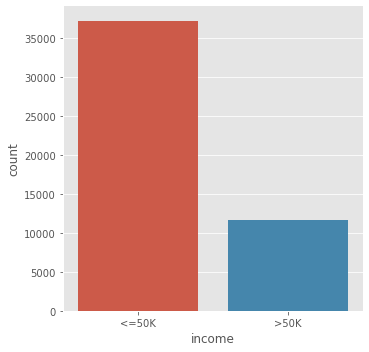

In [7]:
# Distribuição das classes (variável income)
sns.catplot(x='income',kind='count',data=df)

In [8]:
df['income'].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

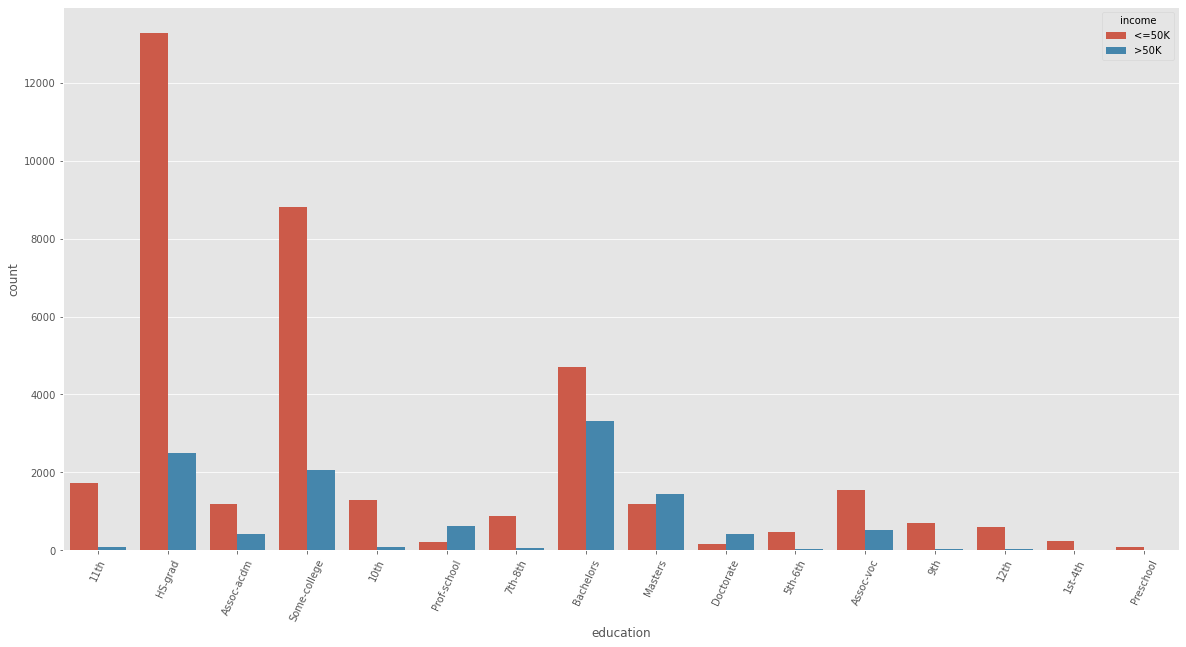

In [9]:
# Distribuição das classes por Nível de Escolaridade
plt.figure(figsize=(20,10))
sns.countplot(data=df, x = 'education',  hue = 'income')
plt.xticks(rotation=65)

In [10]:
df['education'].value_counts()

HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: education, dtype: int64

In [11]:
# Verificando a menor e a maior jornada de trabalho.
print(df['hours-per-week'].min())
print(df['hours-per-week'].max())

1
99


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

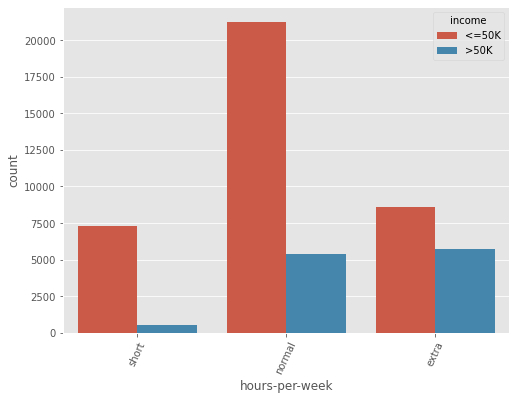

In [12]:
# Para uma melhor visualização vamos agrupar as horas trabalhadas em 3 categorias:
# 0-30 (jornada curta)
# 30-40 (jornada normal)
# 40-100 (jornada extra)

df['hours-per-week'] = pd.cut(df['hours-per-week'],[0,30,40,100], labels =['short','normal','extra'])

# Distribuição das classes por Horas trabalhadas
plt.figure(figsize=(8,6))
sns.countplot(data=df, x = 'hours-per-week',  hue = 'income')
plt.xticks(rotation=65)

In [13]:
df['hours-per-week'].value_counts()

normal    26639
extra     14352
short      7851
Name: hours-per-week, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

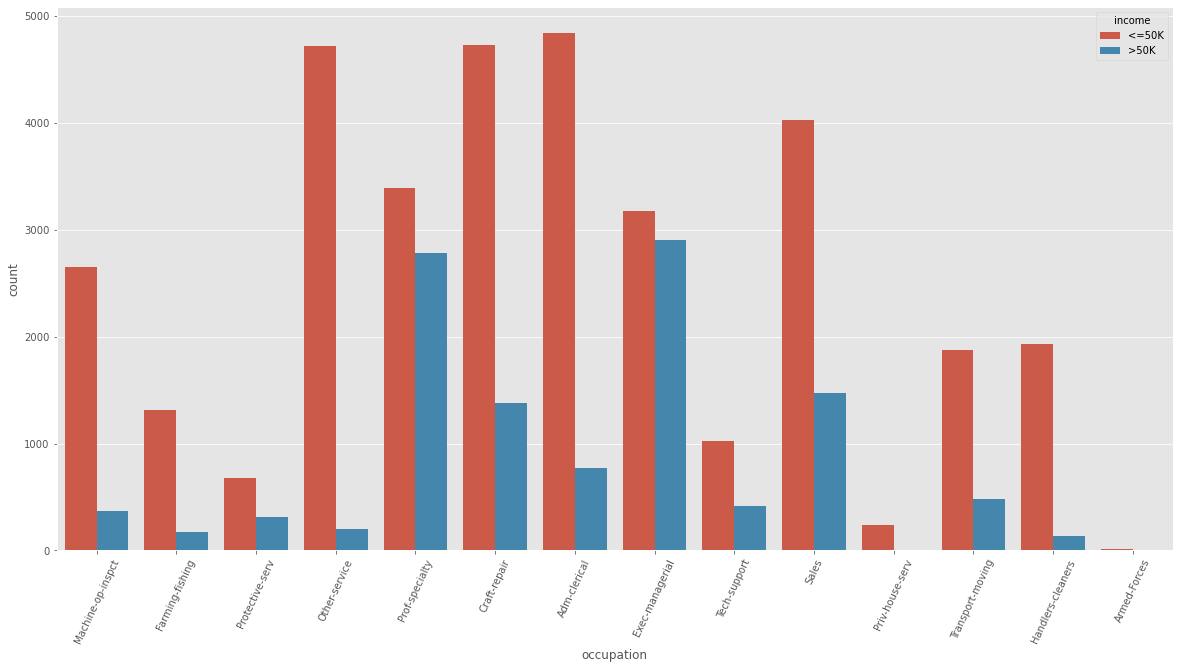

In [14]:
# Distribuição das classes de acordo com a ocupação
plt.figure(figsize=(20,10))
sns.countplot(data=df, x = 'occupation',  hue = 'income')
plt.xticks(rotation=65)

In [15]:
df['occupation'].value_counts()

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: occupation, dtype: int64

# Relação das colunas age,sex e race com a coluna income.

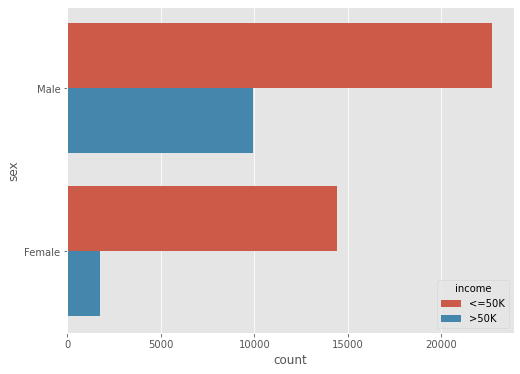

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(y="sex", hue='income', data=df)

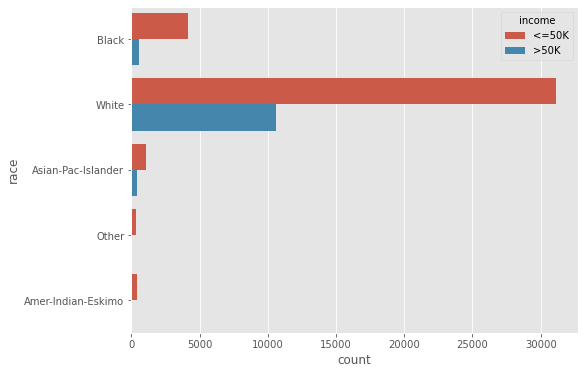

In [17]:
plt.figure(figsize=(8,6))
sns.countplot(y="race", hue='income', data=df)

In [18]:
# Verificando a idade mínima e máxima do dataset.
print(f'A idade mínima é: {df.age.min()} anos')
print(f'A idade máxima é: {df.age.max()} anos')

A idade mínima é: 17 anos
A idade máxima é: 90 anos


(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

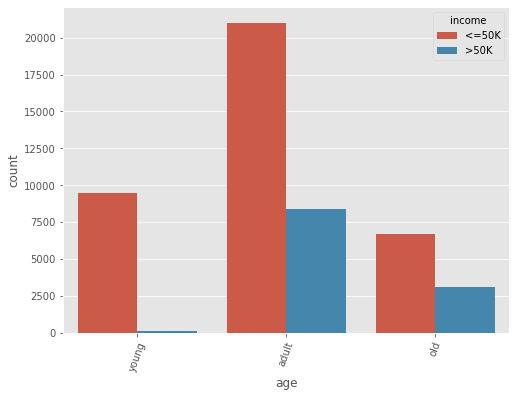

In [19]:
# Para uma melhor visualização vamos agrupar as idades em 3 categorias:
# 0-25 anos (jovens)
# 25-50 anos (adultos)
# 50-100 anos (idosos)
df['age'] = pd.cut(df['age'],[0,25,50,100], labels =['young','adult','old'])

# Verificando como ficou a distribuição.
plt.figure(figsize=(8,6))
sns.countplot(data=df, x = 'age',  hue = 'income')
plt.xticks(rotation=70)

In [20]:
# Verificando a quantidade de valores nulos no dataset.
total = df.isnull().sum().sort_values(ascending=False)
percent = df.isnull().sum()/df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, sort=False, keys=['total', 'percent'])
missing_data[missing_data['percent']!=0]

,total,percent
occupation,2809,0.057512
workclass,2799,0.057307
native-country,857,0.017546


In [21]:
# Preenchendo os valores nulos da coluna 'workclass'.
top = 'Private'
df['workclass'] = df['workclass'].fillna(top)

In [22]:
# Preenchendo os valores nulos da coluna 'occupation'.
top = 'United-States'
df['occupation'] = df['occupation'].fillna(top)

In [23]:
# Preenchendo os valores nulos da coluna 'native-country'.
top = 'Prof-specialty'
df['native-country'] = df['native-country'].fillna(top)

In [24]:
# Verificando se ainda existem valores nulos no Dataset.
if df.isnull().sum().sort_values(ascending=False).any() != 0:
    print(f'Existe valores nulos no dataset? {True}')
else:
    print(f'Existe valores nulos no dataset? {False}')

Existe valores nulos no dataset? False


In [25]:
# Criando uma nova coluna com a renda final.
df['capital_last'] = df['capital-gain'] - df['capital-loss']

In [26]:
# Removendo as features irrelevantes.
# A coluna 'educational-num' está preenchida com o código referente a cada nível de escolaridade, dessa maneira podemos excluir a coluna 'education'.
# As colunas 'capital-gain' e 'capital-loss' estão representadas pela nova coluna que criamos anteriormente.
def remove_features(lista_features):
    for i in lista_features:
        df.drop(i, axis=1, inplace=True)
remove_features(['capital-gain','capital-loss','education'])

In [27]:
# Trasnformando as variáveis categóricas em numéricas.
cols = df[df.select_dtypes(['object']).columns]

for c in cols:
    encoding = LabelEncoder()
    encoding.fit(list(df[c].values))
    df[c] = encoding.transform(list(df[c].values))
df = pd.get_dummies(df)

In [28]:
df.head()

,workclass,educational-num,marital-status,occupation,relationship,race,sex,native-country,income,capital_last,age_young,age_adult,age_old,hours-per-week_short,hours-per-week_normal,hours-per-week_extra
0,3,7,4,6,3,2,1,39,0,0,1,0,0,0,1,0
1,3,9,2,4,0,4,1,39,0,0,0,1,0,0,0,1
2,1,12,2,10,0,4,1,39,1,0,0,1,0,0,1,0
3,3,10,2,6,0,2,1,39,1,7688,0,1,0,0,1,0
4,3,10,4,14,3,4,0,39,0,0,1,0,0,1,0,0


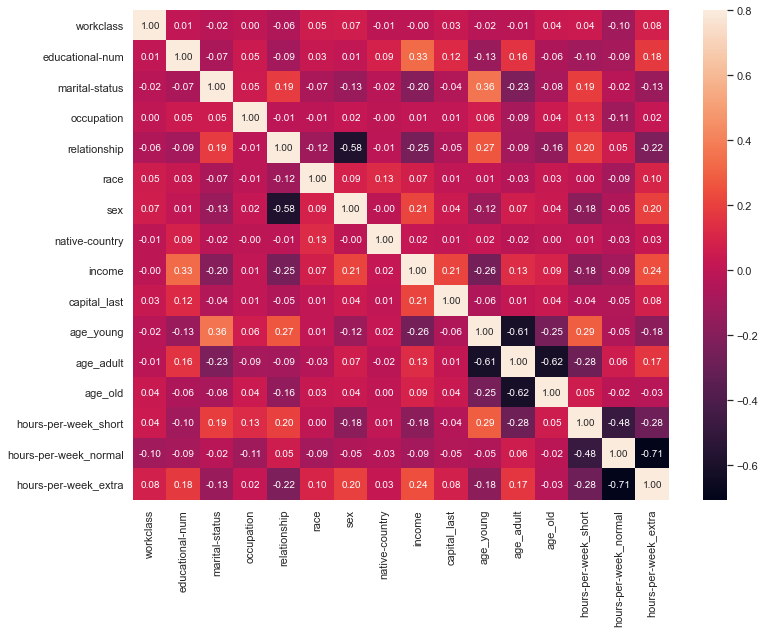

In [29]:
# Matriz de correlação
corr = df.corr()
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 10}, annot=True, fmt='.2f')

In [30]:
corr_list = corr['income'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

educational-num          0.332613
hours-per-week_extra     0.243127
sex                      0.214628
capital_last             0.214356
age_adult                0.133381
age_old                  0.092733
race                     0.070934
native-country           0.020073
occupation               0.007275
workclass               -0.000511
hours-per-week_normal   -0.092061
hours-per-week_short    -0.176724
marital-status          -0.199072
relationship            -0.253214
age_young               -0.257496
Name: income, dtype: float64

# Verificando as features mais importantes para o modelo.

In [31]:
# Separando a classe dos Dados.
previsores = df.drop('income',axis=1)
classe = df['income']

In [32]:
clf=RandomForestClassifier(n_estimators=100, random_state=7)
clf.fit(previsores, classe)

RandomForestClassifier(random_state=7)

In [33]:
feature_imp = pd.Series(clf.feature_importances_,index=previsores.columns).sort_values(ascending=False)
feature_imp

capital_last             0.227708
educational-num          0.185721
relationship             0.144930
occupation               0.109679
marital-status           0.108843
workclass                0.058868
native-country           0.036384
hours-per-week_extra     0.024598
age_young                0.024525
race                     0.023116
sex                      0.018543
hours-per-week_short     0.012996
hours-per-week_normal    0.008717
age_adult                0.007869
age_old                  0.007505
dtype: float64

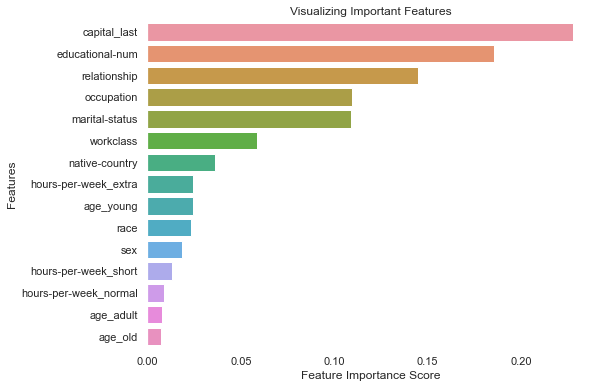

In [34]:
plt.figure(figsize=(8,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [35]:
# Selecionando as features de maior importância.
features_selected = []
for feature,importance in feature_imp.iteritems():
    if importance > 0.03:
        print(f'{feature}: {round(importance * 100)}%')
        features_selected.append(feature)

capital_last: 23%
educational-num: 19%
relationship: 14%
occupation: 11%
marital-status: 11%
workclass: 6%
native-country: 4%


In [39]:
# Treinando os modelos utilizando apenas as features selecionadas.
X = df[features_selected]
y = df['income']

# Avaliação dos modelos de Machine Learning

In [37]:
# Criando modelo de Machine Learning a partir de cada algoritmo

pipelines = []
pipelines.append(('Scaled-LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('Scaled-KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('Scaled-CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('Scaled-NB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('Scaled-GB', Pipeline([('Scaler', StandardScaler()),('GB', GradientBoostingClassifier())])))
pipelines.append(('Scaled-XGB', Pipeline([('Scaler', StandardScaler()),('XGB', XGBClassifier())])))
pipelines.append(('Scaled-LGBM', Pipeline([('Scaler', StandardScaler()),('LGBM', LGBMClassifier())])))
pipelines.append(('Scaled-RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
resultados = []
nomes = []

# Percorrendo cada um dos modelos
for nome, modelo in pipelines:
    kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)
    cross_val_result = model_selection.cross_val_score(modelo, 
                                                     previsores, 
                                                     classe, 
                                                     cv = kfold, 
                                                     scoring = 'accuracy')
    resultados.append(cross_val_result)
    nomes.append(nome)
    texto = "%s: %f (%f)" % (nome, cross_val_result.mean(), cross_val_result.std())
    print(texto)

Scaled-LR: 0.817657 (0.004957)
Scaled-KNN: 0.835244 (0.006505)
Scaled-CART: 0.855534 (0.004263)
Scaled-NB: 0.802977 (0.004809)
Scaled-GB: 0.862106 (0.002767)
[12:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:01:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'err

In [40]:
# Tunning dos modelos

# # Definindo a escala
X = StandardScaler().fit_transform(X)

# Montando a grid
grid = {'max_depth': [2, 3, 4, 5, 6],
        'n_estimators': [10, 50, 100, 200],
        'learning_rate': [0.001, 0.01, 0.1, 1]}
                      
# Criando o modelo
lgbm = LGBMClassifier()

# Definindo K
kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)

# Testando diferenets combinações com os parâmetros
grid = RandomizedSearchCV(estimator = lgbm, param_distributions = grid, cv = kfold, scoring = 'accuracy')
grid.fit(X, y)

# Print do resultado
print(f'Melhor parâmetro:{grid.best_params_}, Score:{grid.best_score_}')

Melhor parâmetro:{'n_estimators': 10, 'max_depth': 6, 'learning_rate': 1}, Score:0.866078423729396


In [41]:
# Preparando a versão final do modelo.
lgbm = LGBMClassifier(n_estimators=10, max_depth=6, learning_rate=1, random_state=7)
lgbm.fit(X, y)
result = cross_val_predict(lgbm, X, y, cv=10)

print(f'Acurácia: {accuracy_score(y, result)}')
print('\n',confusion_matrix(y, result))
print('\n',classification_report(y, result))

Acurácia: 0.8652389337045985

 [[35162  1993]
 [ 4589  7098]]

               precision    recall  f1-score   support

           0       0.88      0.95      0.91     37155
           1       0.78      0.61      0.68     11687

    accuracy                           0.87     48842
   macro avg       0.83      0.78      0.80     48842
weighted avg       0.86      0.87      0.86     48842



In [42]:
# Salvando em Disco
pickle.dump(lgbm, open('modelo.sav', 'wb'))